# The Big One - Ground Shaking & Landslides Coming to a Neighborhood Near You
UW Geospatial Data Analysis  
CEE498/CEWA599  
Ryan Rasanen & Brek Chiles

### Introduction

#### Project: The Nowicki et al. (2018) Empirical Model for Near-Real-Time Assessment of Seismically Induced Landslides
1. Brief introduction of the model using an example
2. Explain steps to implement the model in python
3. Analyze the model results
    * Calculate areas at high and low risk of landslide
    * Areal coverage of landsliding expected in a given grid cell
    * Pseudo landslide susceptibility calculation
    * Emergency response scenario

#### What is the Nowicki et al. (2018) model?
* A Global model that can predict near-real time probability of landslides based on globally available landslide susceptibility data and a ShakeMap (ground motions from a future earthquake)


#### Method
* Logistic regression used to relate 23 landslide case histories with spatially distributed estimates of ground shaking, topographic slope, lithology, land cover type, and a topographic index to provide an empirical model of landslide distribution.
* Empirical model then applied to other landslide case histories to test performance

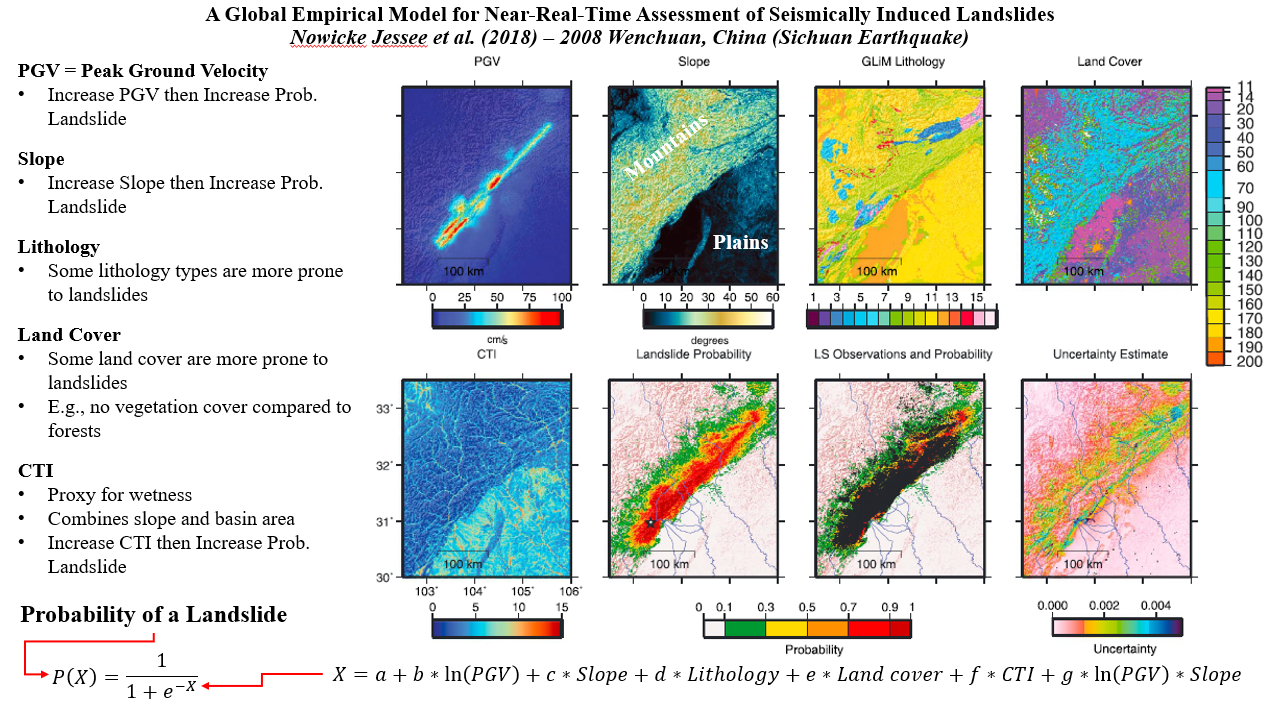

# Part 1: Create Landslide Probability Model

### Workflow
* Modify input rasters and use gdalwarp to project, clip, and resample rasters
* Reclassify land cover (GLOB) and lithology (GLIM) datasets
* Use Nowicki et al. (2018) equation to create LS probability model

In [1]:
# Import modules 
import os
import requests
import contextily as ctx
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

In [2]:
from matplotlib_scalebar.scalebar import ScaleBar

### CTI
* Original authors of CTI raster multiplied CTI values by 100 "to save" decimal places
* To get the correct CTI value we divide by 100
* Update the datatype
* save CTI as a new raster
* Use gdalwarp updated CTI raster to project, clip, and resample it

In [3]:
# Set relative path to the initial cti file
cti_fn = 'data/cti/cti_initial.tif'

# Now open the cti tif file
cti_src = rio.open(cti_fn)

# Now read the cti file and set masked=True to mask the -32768 values (we now have a numpy masked array)
cti_initial = cti_src.read(1, masked=True)

# Divide cti by 100 as authors multiplied cti by 100 to "save decimal places" so we need to undo that to get the actual cti values
cti_initial_mod = cti_initial/100

In [4]:
# Create a variable for the input rasters profile data
profile = cti_src.profile

# Update the profile to have the needed datatype of float
profile.update(dtype=rio.float64)
profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -32768.0, 'width': 4440, 'height': 4912, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333331163, 0.0, -124.79583333333296,
       0.0, -0.000833333333333115, 49.51666666666807), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [5]:
# Specify output relative filepath (including the output filename)
out_fp = 'data/cti/cti_initial_mod.tif'
out_fp

'data/cti/cti_initial_mod.tif'

In [6]:
# Save the modified cti file as a .tif
if not os.path.exists(out_fp):
    with rio.open(out_fp, "w", **profile) as dst:
        dst.write(cti_initial_mod, 1)

In [7]:
# Set name of the input and output files
# input_crs = 'EPSG:4326'    # Do not need to include gdalwarp knows from input file
output_crs = 'EPSG:32610'
cti_input_fn = 'data/cti/cti_initial_mod.tif'
cti_output_fn = 'data/cti/cti_warp.tif'

In [8]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(cti_output_fn):
    !gdalwarp -r bilinear -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $cti_input_fn $cti_output_fn

In [9]:
# Set relative path to the warped cti file
cti_warp_fn = 'data/cti/cti_warp.tif'

# Now open the cti tif file
cti_warp_src = rio.open(cti_warp_fn)

# Now read the cti file and set masked=True to mask the -32768 values
cti_warp = cti_warp_src.read(1, masked=True)

# Get the plotting extent
cti_warp_extent = rio.plot.plotting_extent(cti_warp_src)

# returns left, right, bottom, top
cti_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### Compute from the GMTED elevation data
* Need to use gdalwarp prior to gdaldem slope
* Use gdalwarp to project, clip, and resample the input elevation raster
* Use gdaldem slope on the elevation raster output by gdalwarp

In [10]:
# Set name of the input and output files
output_crs = 'EPSG:32610'
elev_input_fn = 'data/slope/gmted_elev_initial.tif'
elev_output_fn = 'data/slope/elev_warp.tif'

In [11]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(elev_output_fn):
    !gdalwarp -r bilinear -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $elev_input_fn $elev_output_fn

In [12]:
# Set relative path to the initial elev file
elev_warp_fn = 'data/slope/elev_warp.tif'

# Output slope filename
slope_fn = 'data/slope/slope_warp.tif'

In [13]:
# gdaldem slope input_dem output_slope_map
# Generates a slope map from any GDAL-supported elevation raster
if not os.path.exists(slope_fn):
    !gdaldem slope $elev_warp_fn $slope_fn

In [14]:
# Now open the output slope from gdaldem and assign it to a variable
slope_src = rio.open(slope_fn)

# Now read the slope file
slope_warp = slope_src.read(1, masked=True)

# Get the plotting extent
slope_warp_extent = rio.plot.plotting_extent(slope_src)

# returns left, right, bottom, top
slope_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### PGV
* Use gdalwarp to project, clip, and resample the input PGV raster

In [15]:
# Set name of the input and output files
output_crs = 'EPSG:32610'
pgv_input_fn = 'data/pgv/pgvwsite_csz010.tif'
pgv_output_fn = 'data/pgv/pgv_warp.tif'

In [16]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(pgv_output_fn):
    !gdalwarp -r bilinear -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $pgv_input_fn $pgv_output_fn

In [17]:
# Set relative path to the warped pgv file
pgv_warp_fn = 'data/pgv/pgv_warp.tif'

# Now open the pgv tif file
pgv_warp_src = rio.open(pgv_warp_fn)

# Now read the pgv file and set masked=True
pgv_warp = pgv_warp_src.read(1, masked=True)

# Get the plotting extent
pgv_warp_extent = rio.plot.plotting_extent(pgv_warp_src)

# returns left, right, bottom, top
pgv_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### Land Cover (GLOB)
* Globcover reclassification, landcover values to coefficients
* Save as a new tif file to input into gdalwarp
* Use gdalwarp to project, clip, and resample the input GLIM raster

In [18]:
# Set relative path to the initial cti file
landcover_fn = 'data/landcover/landcover_initial.tif'

# Now open the cti tif file
landcover_src = rio.open(landcover_fn)

# Now read the cti file and set masked=True to mask the -32768 values (we now have a numpy masked array)
landcover_initial = landcover_src.read(1, masked=True)

| Landcover Type | GLOB Cover Value | Coefficient |
| :---: | :---: | :---: |
| Rainfed croplands | 14 | 0.91 |
| Mosaic cropland | 20 | 0.88 |
| Mosaic vegetation | 30 | 0.78 |
| Closed to open broadleaved evergreen or semideciduous forest | 40 | 0.68 |
| Closed broadleaved deciduous forest | 50 | 0.30 |
| Rainfed croplands | 60 | 1.77 |
| Closed needleleaved evergreen forest | 70 | 1.71 |
| Open needleleaved deciduous or evergreen forest | 90 | -1.26 |
| Closed to open mixed broadleaved and needleleaved forest | 100 | 1.50 |
| Mosaic forest or shrubland/grassland | 110 | 0.68 |
| Mosaic grassland/forest or shrubland | 120 | 1.13 |
| Closed to open broadleaved or needleleaved, evergreen or deciduous  | 130 | 0.79 |
| Closed to open herabceous vegetation | 140 | 1.03 |
| Sparse vegetation | 150 | 0.54 |
| Closed to open broadleaved forest regulary flooded | 160 | 2.34 |
| Closed to open grassland or woody vegetation on regularly flooded or waterlogged, soil, fresh, brackish, or saline water | 180 | 1.19 |
| Artificial surfaces and associated areas | 190 | 0.30 |
| Bare areas | 200 | -0.06 |
| Water Bodies | 210 | NaN |
| Permanent snow and ice | 220 | -0.18 |
| No data | 230 | -1.08 |

## GLOB reclassification, cover values to coefficients

In [19]:
glob_copy = landcover_initial.copy()  
glob_copy_flt = np.asarray(glob_copy, dtype=np.float, order='C') # Make the integer values floats before reclassifying
glob_copy_flt[np.where(glob_copy_flt == 11.)] = np.nan 
glob_copy_flt[np.where(glob_copy_flt == 14.)] = 0.91 
glob_copy_flt[np.where(glob_copy_flt == 20.)] = 0.88 
glob_copy_flt[np.where(glob_copy_flt == 30.)] = 0.78 
glob_copy_flt[np.where(glob_copy_flt == 40.)] = 0.68 
glob_copy_flt[np.where(glob_copy_flt == 50.)] = 0.3 
glob_copy_flt[np.where(glob_copy_flt == 60.)] = 1.77
glob_copy_flt[np.where(glob_copy_flt == 70.)] = 1.71 
glob_copy_flt[np.where(glob_copy_flt == 90.)] = -1.26 
glob_copy_flt[np.where(glob_copy_flt == 100.)] = 1.5 
glob_copy_flt[np.where(glob_copy_flt == 110.)] = 0.68 
glob_copy_flt[np.where(glob_copy_flt == 120.)] = 1.13 
glob_copy_flt[np.where(glob_copy_flt == 130.)] = 0.79 
glob_copy_flt[np.where(glob_copy_flt == 140.)] = 1.03 
glob_copy_flt[np.where(glob_copy_flt == 150.)] = 0.54 
glob_copy_flt[np.where(glob_copy_flt == 160.)] = 2.34
glob_copy_flt[np.where(glob_copy_flt == 170.)] = np.nan
glob_copy_flt[np.where(glob_copy_flt == 180.)] = 1.19  
glob_copy_flt[np.where(glob_copy_flt == 190.)] = 0.3  
glob_copy_flt[np.where(glob_copy_flt == 200.)] = -0.06 
glob_copy_flt[np.where(glob_copy_flt == 210.)] = np.nan
glob_copy_flt[np.where(glob_copy_flt == 220.)] = -0.18  
glob_copy_flt[np.where(glob_copy_flt == 230.)] = -1.08
glob_copy_flt

array([[ 0.  ,   nan,   nan, ...,  0.54,  0.54,  0.54],
       [ 0.  ,   nan,   nan, ..., -1.26,  0.79,  0.79],
       [ 0.  ,   nan,   nan, ..., -1.26,  0.79,  0.79],
       ...,
       [ 0.  ,   nan,   nan, ...,  0.68,  0.78,  0.78],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [20]:
glob_reclass_fp = 'data/landcover/glob_reclass.tif'
if not os.path.exists(glob_reclass_fp):
    with rio.open(glob_reclass_fp, "w", **profile) as dst:
        dst.write(glob_copy_flt, 1)

In [21]:
# Set name of the input and output files
output_crs = 'EPSG:32610'
glob_input_fn = 'data/landcover/glob_reclass.tif'
glob_output_fn = 'data/landcover/landcover_warp.tif'

In [22]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(glob_output_fn):
    !gdalwarp -r near -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $glob_input_fn $glob_output_fn

In [23]:
# Set relative path to the warped GLOB file
glob_warp_fn = 'data/landcover/landcover_warp.tif'

# Now open the glob tif file
glob_warp_src = rio.open(glob_warp_fn)

# Now read the glob file and set masked=True
glob_warp = glob_warp_src.read(1, masked=True)

# Get the plotting extent
glob_warp_extent = rio.plot.plotting_extent(glob_warp_src)

# returns left, right, bottom, top
glob_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### Lithology (GLIM)
* Glim reclassification, lithology values to coefficients
* Save as a new tif file to input into gdalwarp
* Use gdalwarp to project, clip, and resample the input GLIM raster

In [24]:
# Set relative path to the initial cti file
lithology_fn = 'data/lithology/lithology_initial.tif'

# Now open the cti tif file
lithology_src = rio.open(lithology_fn)

# Now read the cti file and set masked=True to mask the -32768 values (we now have a numpy masked array)
lithology_initial = lithology_src.read(1, masked=True)

| GLIM Lithology Name | Glim Value | Coefficient |
| :---: | :---: | :---: |
| Intermediate Volcanic Rock | 1 | -0.81 |
| Basic Volcanic Rocks | 2 | -1.50 |
| Acid Plutonic Rocks | 3 | -0.78 |
| Metamorphic Rocks | 4 | -1.87 |
| Unconsolidated Sediments | 5 | -3.22 |
| Siliciclastic Sedimentary Rocks | 6 | -1.92 |
| Basic Plutonic Rocks | 7 | -1.88 |
| Intermediate Plutonic Rocks | 8 | -1.61 |
| Mixed Sedimentary Rocks | 9 | -1.36 |
| Water Bodies | 10 | NaN |
| Pyroclastics | 11 | -1.05 |
| Carbonate Sedimentary Rocks  | 12 | -0.95 |
| Acid Volcanic Rocks | 13 | -1.54 |
| No Data | 14 | -0.66 |
| Evaporites | 15 | NaN |

In [25]:
glim_copy = lithology_initial.copy()  
glim_copy_flt = np.asarray(glim_copy, dtype=np.float, order='C') # Make the integer values floats before reclassifying
glim_copy_flt[np.where(glim_copy_flt == 1.)] = -0.81
glim_copy_flt[np.where(glim_copy_flt == 2.)] = -1.5 
glim_copy_flt[np.where(glim_copy_flt == 3.)] = -0.78 
glim_copy_flt[np.where(glim_copy_flt == 4.)] = -1.87 
glim_copy_flt[np.where(glim_copy_flt == 5.)] = -3.22 
glim_copy_flt[np.where(glim_copy_flt == 6.)] = -1.92 
glim_copy_flt[np.where(glim_copy_flt == 7.)] = -1.88 
glim_copy_flt[np.where(glim_copy_flt == 8.)] = -1.61 
glim_copy_flt[np.where(glim_copy_flt == 9.)] = -1.36 
glim_copy_flt[np.where(glim_copy_flt == 10.)] = np.nan 
glim_copy_flt[np.where(glim_copy_flt == 11.)] = -1.05 
glim_copy_flt[np.where(glim_copy_flt == 12.)] = -0.95 
glim_copy_flt[np.where(glim_copy_flt == 13.)] = -1.54 
glim_copy_flt[np.where(glim_copy_flt == 14.)] = -0.66
glim_copy_flt[np.where(glim_copy_flt == 15.)] = np.nan
glim_copy_flt[np.where(glim_copy_flt == -128.)] = np.nan 
glim_copy_flt

array([[-1.36, -1.36, -1.36, ..., -1.61, -1.61, -1.61],
       [-1.36, -1.36, -1.36, ..., -1.61, -1.61, -1.61],
       [-1.36, -1.36, -1.36, ..., -1.61, -1.61, -1.61],
       ...,
       [  nan,   nan,   nan, ..., -1.5 , -1.5 , -1.5 ],
       [  nan,   nan,   nan, ..., -1.5 , -1.5 , -1.5 ],
       [  nan,   nan,   nan, ..., -1.5 , -1.5 , -1.5 ]])

In [26]:
glim_reclass_fp = 'data/lithology/glim_reclass.tif'
if not os.path.exists(glim_reclass_fp):
    with rio.open(glim_reclass_fp, "w", **profile) as dst:
        dst.write(glim_copy_flt, 1)

In [27]:
# Set name of the input and output files
output_crs = 'EPSG:32610'
glim_input_fn = 'data/lithology/glim_reclass.tif'
glim_output_fn = 'data/lithology/lithology_warp.tif'

In [28]:
# Use gdalwarp to project, trim, and resample raster
if not os.path.exists(glim_output_fn):
    !gdalwarp -r near -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER -t_srs $output_crs -te 367000 5180000 640000 5430000 -te_srs $output_crs -tr 200 200 $glim_input_fn $glim_output_fn

In [29]:
# Set relative path to the warped Glim file
glim_warp_fn = 'data/lithology/lithology_warp.tif'

# Now open the glim tif file
glim_warp_src = rio.open(glim_warp_fn)

# Now read the glim file and set masked=True
glim_warp = glim_warp_src.read(1, masked=True)

# Get the plotting extent
glim_warp_extent = rio.plot.plotting_extent(glim_warp_src)

# returns left, right, bottom, top
glim_warp_extent

(367000.0, 640000.0, 5180000.0, 5430000.0)

### Probability of Landslide

In [30]:
# Set up the Nowicki et al. (2018) Probability of Landslide model

# Our geospatial input arrays are:
# pgv_warp
# slope_warp
# glim_warp
# glob_warp
# cti_warp

# specify the regression coefficients (note lithology (d) and landcover (e) coefficients are already included in their warped arrays)
a = -6.3
b = 1.65
c = 0.06
f = 0.03
g = 0.01

# Part 1 - Probability of Landslide element wise calcs (note np.log takes the natural logarithm)
# Equation 8 in Nowicki et al. (2018)
# np.ma.log used to mask values
t = a+(b*(np.ma.log(pgv_warp)))+(c*slope_warp)+glim_warp+glob_warp+(f*cti_warp)+(g*(np.ma.log(pgv_warp))*slope_warp)

# Part 2 - Probability of Landslide calc
# Equation 3 in Nowicki et al. (2018)
prob_ls = (1/(1+(np.exp(-t))))*100

In [31]:
# Note plots color bar limits may not extend to maximum value for viewability reasons
# Thus, show maximum value for each input array into the Probability of Landslide equation here instead
# Lithology and Landcover are not shown here because they have qualitative placeholders reclassed with coefficients

# Minimum for relevant input and output variables
print("The minimum PGV value is {:0.2f} cm/s".format(pgv_warp.min()))
print("The minimum slope value is {:0.2f} degrees".format(slope_warp.min()))
print("The minimum CTI value is {:0.2f}".format(cti_warp.min()))
print("The minimum Probability of Landslide value is {:0.2f}%".format(prob_ls.min()))

print("")

# Maximum for relevant input and output variables
print("The maximum PGV value is {:0.2f} cm/s".format(pgv_warp.max()))
print("The maximum slope value is {:0.2f} degrees".format(slope_warp.max()))
print("The maximum CTI value is {:0.2f}".format(cti_warp.max()))
print("The maximum Probability of Landslide value is {:0.2f}%".format(prob_ls.max()))

The minimum PGV value is 0.00 cm/s
The minimum slope value is 0.00 degrees
The minimum CTI value is 4.18
The minimum Probability of Landslide value is 0.00%

The maximum PGV value is 436.72 cm/s
The maximum slope value is 58.52 degrees
The maximum CTI value is 16.57
The maximum Probability of Landslide value is 99.97%


### Plot of input rasters and output probability of landslide

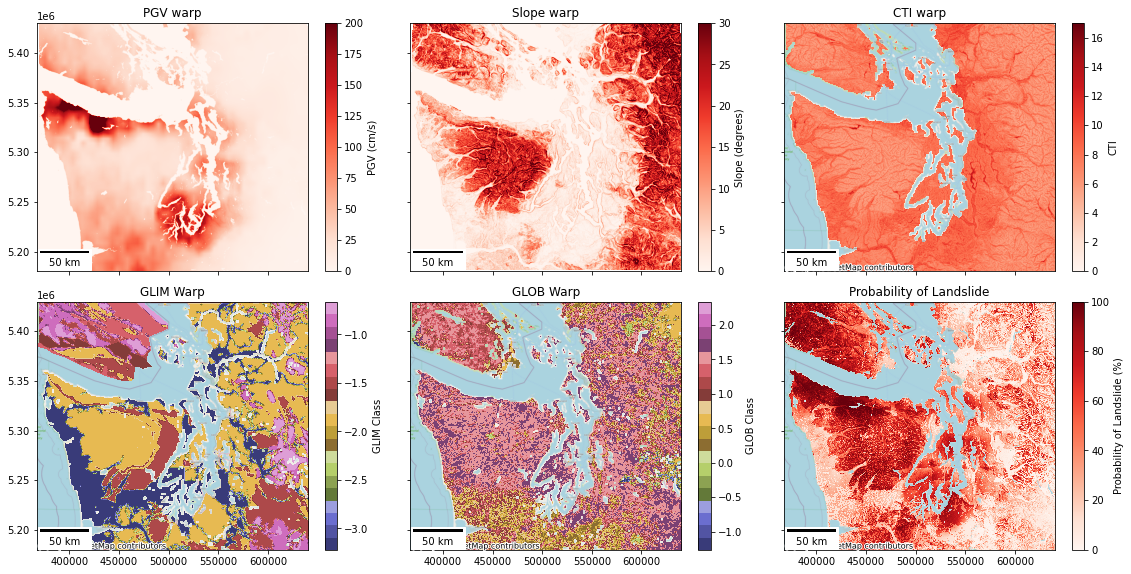

In [32]:
# Plots for each of the raster input parameters (Will choose better colors in the future)

f, ax = plt.subplots(2,3, figsize=(16, 8), sharex=True, sharey=True)

# PGV - PGV max is around ~437 cm/s, but for viewability set it to 200 cm/s
pgv_warp_plot = ax[0][0].imshow(pgv_warp, cmap='Reds', vmin=0, vmax=200, extent=pgv_warp_extent);
ax[0][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][0].set_title('PGV warp')
pgv_cbar = f.colorbar(pgv_warp_plot, ax=ax[0][0])
pgv_cbar.set_label('PGV (cm/s)')

# Slope
slope_plot = ax[0][1].imshow(slope_warp, cmap='Reds', vmin=0, vmax=30, extent=slope_warp_extent);
ax[0][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][1].set_title('Slope warp')
slope_cbar = f.colorbar(slope_plot, ax=ax[0][1]);
slope_cbar.set_label('Slope (degrees)')

# CTI
ctx.add_basemap(ax=ax[0][2], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
cti_warp_plot = ax[0][2].imshow(cti_warp, cmap='Reds', vmin=0, vmax=17, extent=cti_warp_extent);
ax[0][2].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][2].set_title('CTI warp')
cti_cbar = f.colorbar(cti_warp_plot, ax=ax[0][2])
cti_cbar.set_label('CTI')

# GLIM LITHOLOGY
ctx.add_basemap(ax=ax[1][0], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
glim_warp_plot = ax[1][0].imshow(glim_warp, cmap='tab20b', extent=glim_warp_extent);
ax[1][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][0].set_title('GLIM Warp')
glim_cbar = f.colorbar(glim_warp_plot, ax=ax[1][0])
glim_cbar.set_label('GLIM Class')

# LAND COVER
ctx.add_basemap(ax=ax[1][1], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
glim_warp_plot = ax[1][1].imshow(glob_warp, cmap='tab20b', extent=glob_warp_extent);
ax[1][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][1].set_title('GLOB Warp')
land_cbar = f.colorbar(glim_warp_plot, ax=ax[1][1])
land_cbar.set_label('GLOB Class')

# Probability of Landslide
ctx.add_basemap(ax=ax[1][2], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot = ax[1][2].imshow(prob_ls, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[1][2].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][2].set_title('Probability of Landslide')
prob_ls_cbar = f.colorbar(prob_ls_plot, ax=ax[1][2])
prob_ls_cbar.set_label('Probability of Landslide (%)')


plt.tight_layout()

* Base Map added to differentiate coastline (OpenStreetMap.Mapnik has the best default water color)
* Lithology and landcover uses different qualitative (discrete) colormap because these represent qualitative lithology and landcover types 
* Interpolation set to 'none' for the Probability of Landslide map to prevent plot from creating NoData sections (default is no longer none)

#### Discussion
* We can see landslides are more likely where shaking is strong and slopes are steep

# Part 2: Estimate High and Low risk Area from the Landslide Probability Model
* Lets consider thresholds of 70 - 100 % for high risk and 0 - 30 % for low risk
* We'll also look at areas above and below 50%

In [33]:
pgv_warp_src.transform

Affine(200.0, 0.0, 367000.0,
       0.0, -200.0, 5430000.0)

We are using rasters with 200 x 200 m cells

### 70 - 100 % and 0 - 30 % Thresholds

In [34]:
# Count cells for high and low risk areas
high_risk = np.count_nonzero((70 <= prob_ls) & (prob_ls <= 100))

low_risk = np.count_nonzero((0 <= prob_ls) & (prob_ls <= 30))

total_cells = np.count_nonzero(prob_ls)

print('High risk cell count : ' + str(high_risk))
print('Low risk cell count : ' + str(low_risk))
print('Total cells : ' + str(total_cells))

High risk cell count : 281704
Low risk cell count : 956904
Total cells : 1706250


In [35]:
# Calculate Area
meta_data = pgv_warp_src.meta
cell_area = meta_data['transform'][0]**2
cell_area

high_area = high_risk * cell_area
low_area = low_risk * cell_area
total_area = total_cells * cell_area

print('High Risk Area : ' + str(high_area/1000000) + ' km^2')
print('Low Risk Area : ' + str(low_area/1000000) + ' km^2')
print('Total Area : ' + str(total_area/1000000) + ' km^2')

High Risk Area : 11268.16 km^2
Low Risk Area : 38276.16 km^2
Total Area : 68250.0 km^2


In [36]:
# As Percentages
high_percent = (high_area / total_area)*100
low_percent = (low_area / total_area)*100 

print('High Risk Area : ' + str(round(high_percent, 2)) + ' %')
print('Low Risk Area : ' + str(round(low_percent, 2)) + ' %')

High Risk Area : 16.51 %
Low Risk Area : 56.08 %


The remaining 27.41 % belongs to the 40 - 60 % range

### 50 % Thresholds

In [37]:
# Count cells for high and low risk areas
high_risk_50 = np.count_nonzero(prob_ls > 50)

low_risk_50 = np.count_nonzero(prob_ls < 50)

print('High risk cell count : ' + str(high_risk_50))
print('Low risk cell count : ' + str(low_risk_50))

High risk cell count : 493201
Low risk cell count : 1213049


In [38]:
# Calculate Area
high_area_50 = high_risk_50 * cell_area
low_area_50 = low_risk_50 * cell_area

print('High Risk Area : ' + str(high_area_50/1000000) + ' km^2')
print('Low Risk Area : ' + str(low_area_50/1000000) + ' km^2')

High Risk Area : 19728.04 km^2
Low Risk Area : 48521.96 km^2


In [39]:
# As Percentages
high_50_percent = (high_area_50 / total_area)*100
low_50_percent = (low_area_50 / total_area)*100 

print('High Risk Area : ' + str(round(high_50_percent, 2)) + ' %')
print('Low Risk Area : ' + str(round(low_50_percent, 2)) + ' %')

High Risk Area : 28.91 %
Low Risk Area : 71.09 %


#### Discussion
* Based on the two sets of thresholds, there is more area at low lisk of landslides than high risk within the Puget Lowland. However, the Olympic Peninsula, Tacoma, and Seattle areas will likely have landslides.
* The areas with low risk of landslides could experience other hazards in the event of intense ground shaking, like liquefaction.
* Important to consider the 200 m resolution of the raster cells, finer resolutions would improve probability model accuracy.

# Part 3: Calculate the portion of each cell that is expected to have landslide occurrence

Nowicki et al. (2018) were aware of their models overprediction so they decided to get the "actual" probability of landslide occurring by introducing a modification factor represented by:

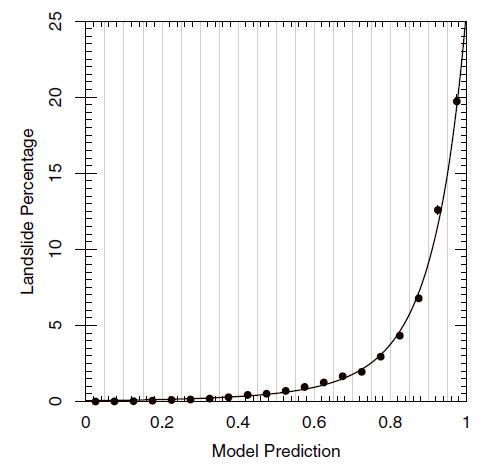

"Relationship between predicted model probabilities and frequency of landslide occurrence used to represent the actual probability of a landslide occurring (i.e., areal coverage of landsliding expected in a given grid cell)" - Nowicket et al. (2018)

#### Calculate areal coverage of landsliding expected in a given grid cell

In [40]:
# Probability of Landslide - output as decimal since we are inputting to areal coverage calculation
prob_ls_dec = (1/(1+(np.exp(-t))))

# Areal percent covered by landslide

# Coefficients
aa = -7.592
bb = 5.237
cc = -3.042
dd = 4.035

# Equation 9 in Nowicki et al. (2018)
perc_ls = np.exp(aa+(bb*prob_ls_dec)+(cc*(prob_ls_dec)**2)+(dd*(prob_ls_dec)**3))*100

In [41]:
print("The minimum areal coverage value is {:0.2f}%".format(perc_ls.min()))

print("")

print("The maximum areal coverage value is {:0.2f}%".format(perc_ls.max()))

The minimum areal coverage value is 0.05%

The maximum areal coverage value is 25.53%


### Plot of input rasters and output areal coverage of landsliding expected in a given grid cell

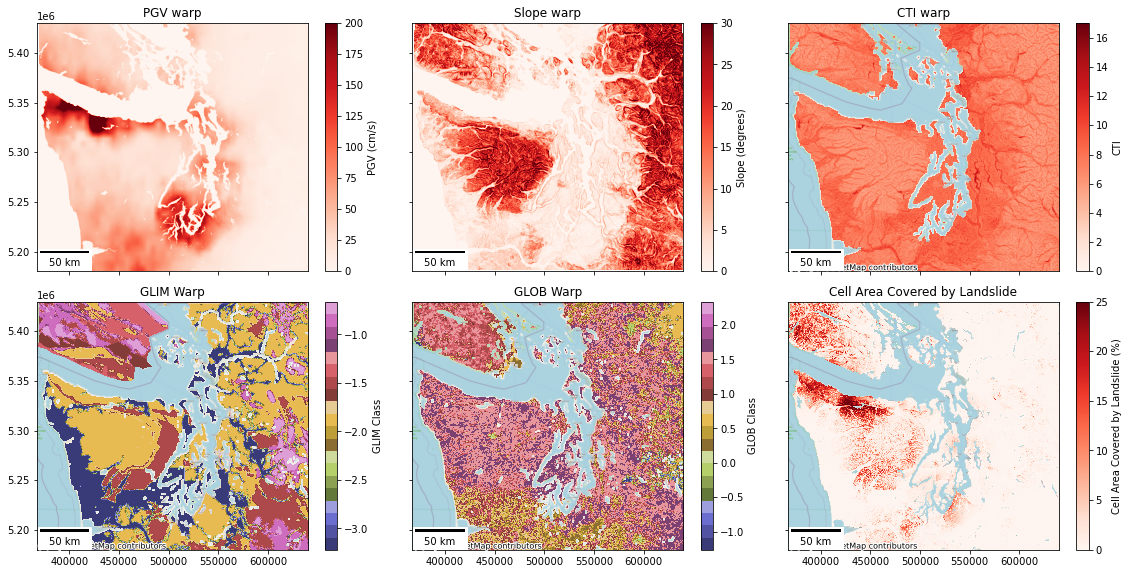

In [42]:
# Plots for each of the raster input parameters (Will choose better colors in the future)

f, ax = plt.subplots(2,3, figsize=(16, 8), sharex=True, sharey=True)

# PGV - PGV max is around ~437 cm/s, but for viewability set it to 200 cm/s
pgv_warp_plot = ax[0][0].imshow(pgv_warp, cmap='Reds', vmin=0, vmax=200, extent=pgv_warp_extent);
ax[0][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][0].set_title('PGV warp')
pgv_cbar = f.colorbar(pgv_warp_plot, ax=ax[0][0])
pgv_cbar.set_label('PGV (cm/s)')

# Slope
slope_plot = ax[0][1].imshow(slope_warp, cmap='Reds', vmin=0, vmax=30, extent=slope_warp_extent);
ax[0][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][1].set_title('Slope warp')
slope_cbar = f.colorbar(slope_plot, ax=ax[0][1]);
slope_cbar.set_label('Slope (degrees)')

# CTI
ctx.add_basemap(ax=ax[0][2], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
cti_warp_plot = ax[0][2].imshow(cti_warp, cmap='Reds', vmin=0, vmax=17, extent=cti_warp_extent);
ax[0][2].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][2].set_title('CTI warp')
cti_cbar = f.colorbar(cti_warp_plot, ax=ax[0][2])
cti_cbar.set_label('CTI')

# GLIM LITHOLOGY
ctx.add_basemap(ax=ax[1][0], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
glim_warp_plot = ax[1][0].imshow(glim_warp, cmap='tab20b', extent=glim_warp_extent);
ax[1][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][0].set_title('GLIM Warp')
glim_cbar = f.colorbar(glim_warp_plot, ax=ax[1][0])
glim_cbar.set_label('GLIM Class')

# LAND COVER
ctx.add_basemap(ax=ax[1][1], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
glim_warp_plot = ax[1][1].imshow(glob_warp, cmap='tab20b', extent=glob_warp_extent);
ax[1][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][1].set_title('GLOB Warp')
land_cbar = f.colorbar(glim_warp_plot, ax=ax[1][1])
land_cbar.set_label('GLOB Class')

# Areal coverage of landsliding expected in a given grid cell
ctx.add_basemap(ax=ax[1][2], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
perc_ls_plot = ax[1][2].imshow(perc_ls, cmap='Reds', vmin=0, vmax=25, extent=slope_warp_extent, interpolation='none');
ax[1][2].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][2].set_title('Cell Area Covered by Landslide')
perc_ls_cbar = f.colorbar(perc_ls_plot, ax=ax[1][2])
perc_ls_cbar.set_label('Cell Area Covered by Landslide (%)')


plt.tight_layout()

#### Let's compare the probability of landslide to the cell area covered by landslide

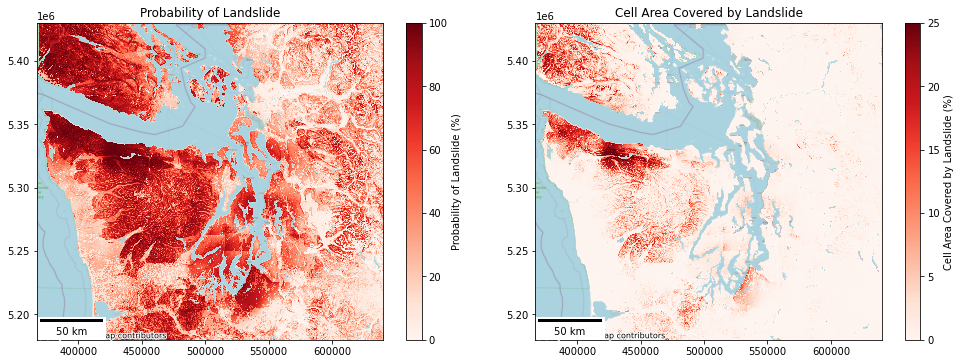

In [43]:
f, ax = plt.subplots(1,2, figsize=(14,5))

# Probability of Landslide
# Note, zorder=1 needed so imshow plot shows up in front of basemap
prob_ls_plot = ax[0].imshow(prob_ls, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none', zorder=1);
ctx.add_basemap(ax=ax[0], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax[0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0].set_title('Probability of Landslide')
prob_ls_cbar = f.colorbar(prob_ls_plot, ax=ax[0])
prob_ls_cbar.set_label('Probability of Landslide (%)')

# Areal coverage of landsliding expected in a given grid cell
# Note, zorder=1 needed so imshow plot shows up in front of basemap
perc_ls_plot = ax[1].imshow(perc_ls, cmap='Reds', vmin=0, vmax=25, extent=slope_warp_extent, interpolation='none', zorder=1);
ctx.add_basemap(ax=ax[1], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax[1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1].set_title('Cell Area Covered by Landslide')
perc_ls_cbar = f.colorbar(perc_ls_plot, ax=ax[1])
perc_ls_cbar.set_label('Cell Area Covered by Landslide (%)')

plt.tight_layout()

#### Discussion
* Note the colorbar limit have changed from 0-100 to 0-25 for the cell area covered by landslide plot (~25 is the max possible for cell area calc)
* Appears to give more reasonable results, but seems a bit suscept
    * i.e., the model overpredicts so let's fit a correction factor - authors provide little detail
* The USGS uses the Probability of Landslide and does not use the correction factor
    * USGS also makes a couple small changes to help the model provide more reasonable results
        * slope < 5 have a probability of landslide = 0 (you wouldn't expect a landslide on flat ground)
        * changing the coefficient for the lithology layer "unconsolidated sediments" from -3.22 to -1.36 to make the model more physically sound

# Part 4: Create a Pseudo Landslide Susceptibility Map

### Workflow
* Input a constant PGV instead in order to generate a pseudo landslide susceptibility raster (still in the form of probability of landslide)
* Analyze the raster output
* Areas more and less susceptible to landslides?
* What major factors influence the results?

### What PGV value should we use for input?
* Let's take the variation of PGV out of the equation and assign a constant PGV.
* Let's use a PGV = 70 cm/s (about the strength for the previous CSZ rupture in Seattle)

### Psuedo Landslide Susceptibility

In [44]:
# Recalculate probability of landslide using a constant PGV with the Nowicki et al. (2018) Probability of Landslide model

# specify the regression coefficients (note lithology (d) and landcover (e) coefficients are already included in their warped arrays)
a = -6.3
b = 1.65
c = 0.06
f = 0.03
g = 0.01

# Part 1 - Probability of Landslide element wise calcs (note np.log takes the natural logarithm)
# Equation 8 in Nowicki et al. (2018)
t_70 = a+(b*(np.log(70)))+(c*slope_warp)+glim_warp+glob_warp+(f*cti_warp)+(g*(np.log(70))*slope_warp)

# Part 2 - Probability of Landslide calc
# Equation 3 in Nowicki et al. (2018)
prob_ls_70 = (1/(1+(np.exp(-t_70))))*100

### Plot of input rasters and output probability of landslide

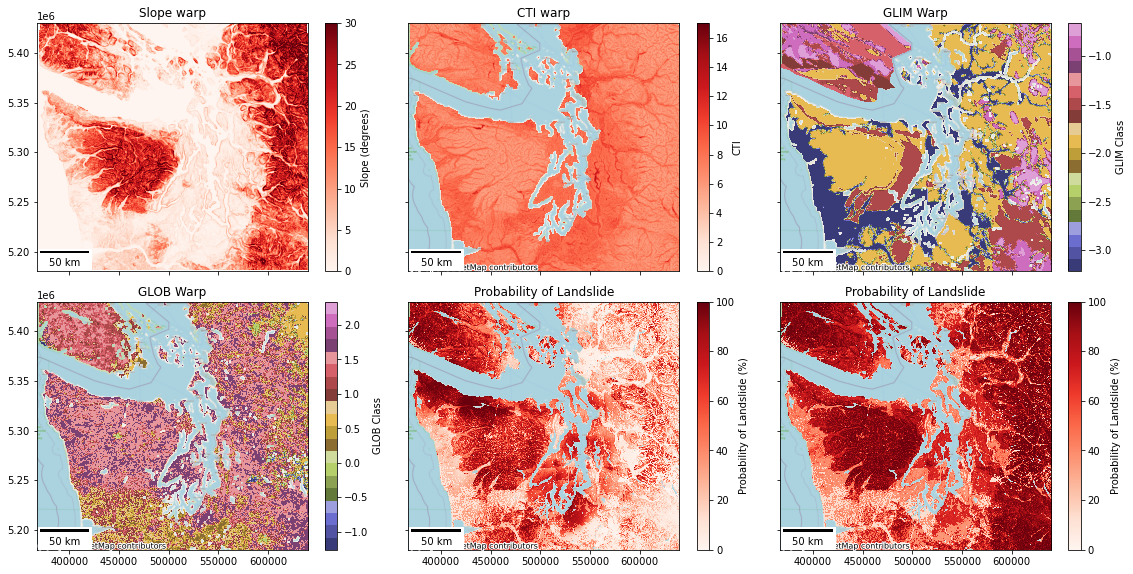

In [45]:
# Plots for each of the raster input parameters (Will choose better colors in the future)

f, ax = plt.subplots(2,3, figsize=(16, 8), sharex=True, sharey=True)

# Slope
slope_plot = ax[0][0].imshow(slope_warp, cmap='Reds', vmin=0, vmax=30, extent=slope_warp_extent);
ax[0][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][0].set_title('Slope warp')
slope_cbar = f.colorbar(slope_plot, ax=ax[0][0]);
slope_cbar.set_label('Slope (degrees)')

# CTI
ctx.add_basemap(ax=ax[0][1], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
cti_warp_plot = ax[0][1].imshow(cti_warp, cmap='Reds', vmin=0, vmax=17, extent=cti_warp_extent);
ax[0][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][1].set_title('CTI warp')
cti_cbar = f.colorbar(cti_warp_plot, ax=ax[0][1])
cti_cbar.set_label('CTI')

# GLIM LITHOLOGY
ctx.add_basemap(ax=ax[0][2], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
glim_warp_plot = ax[0][2].imshow(glim_warp, cmap='tab20b', extent=glim_warp_extent);
ax[0][2].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][2].set_title('GLIM Warp')
glim_cbar = f.colorbar(glim_warp_plot, ax=ax[0][2])
glim_cbar.set_label('GLIM Class')

# LAND COVER
ctx.add_basemap(ax=ax[1][0], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
glim_warp_plot = ax[1][0].imshow(glob_warp, cmap='tab20b', extent=glob_warp_extent);
ax[1][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][0].set_title('GLOB Warp')
land_cbar = f.colorbar(glim_warp_plot, ax=ax[1][0])
land_cbar.set_label('GLOB Class')

# Probability of Landslide
ctx.add_basemap(ax=ax[1][1], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot = ax[1][1].imshow(prob_ls, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[1][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][1].set_title('Probability of Landslide')
prob_ls_cbar = f.colorbar(prob_ls_plot, ax=ax[1][1])
prob_ls_cbar.set_label('Probability of Landslide (%)')

# Probability of Landslide - constant PGV
ctx.add_basemap(ax=ax[1][2], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot_70 = ax[1][2].imshow(prob_ls_70, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[1][2].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][2].set_title('Probability of Landslide')
prob_ls_cbar_70 = f.colorbar(prob_ls_plot_70, ax=ax[1][2])
prob_ls_cbar_70.set_label('Probability of Landslide (%)')


plt.tight_layout()

#### Discussion
* Areas most susceptible to landslides are in mountainous regions
* By using a constant PGV we can examine the influence of other factors on the probability of landslide
    * The Probability of landslide is heavily influenced by slope as we would expect
    * Lithology, landcover, and cti play a smaller role

### Analyzing additional constant PGV scenarios

In [46]:
# Set up the Nowicki et al. (2018) Probability of Landslide model

# specify the regression coefficients (note lithology (d) and landcover (e) coefficients are already included in their warped arrays)
a = -6.3
b = 1.65
c = 0.06
f = 0.03
g = 0.01

# Part 1 - Probability of Landslide element wise calcs (note np.log takes the natural logarithm)
# Equation 8 in Nowicki et al. (2018)
t_2 = a+(b*(np.log(2)))+(c*slope_warp)+glim_warp+glob_warp+(f*cti_warp)+(g*(np.log(2))*slope_warp)
t_20 = a+(b*(np.log(20)))+(c*slope_warp)+glim_warp+glob_warp+(f*cti_warp)+(g*(np.log(20))*slope_warp)
t_50 = a+(b*(np.log(50)))+(c*slope_warp)+glim_warp+glob_warp+(f*cti_warp)+(g*(np.log(50))*slope_warp)
t_100 = a+(b*(np.log(100)))+(c*slope_warp)+glim_warp+glob_warp+(f*cti_warp)+(g*(np.log(100))*slope_warp)
t_150 = a+(b*(np.log(150)))+(c*slope_warp)+glim_warp+glob_warp+(f*cti_warp)+(g*(np.log(150))*slope_warp)
t_200 = a+(b*(np.log(200)))+(c*slope_warp)+glim_warp+glob_warp+(f*cti_warp)+(g*(np.log(200))*slope_warp)

# Part 2 - Probability of Landslide calc
# Equation 3 in Nowicki et al. (2018)
prob_ls_2 = (1/(1+(np.exp(-t_2))))*100     # PGV = 10 cm/s
prob_ls_20 = (1/(1+(np.exp(-t_20))))*100     # PGV = 20 cm/s
prob_ls_50 = (1/(1+(np.exp(-t_50))))*100     # PGV = 50 cm/s
prob_ls_100 = (1/(1+(np.exp(-t_100))))*100   # PGV = 100 cm/s
prob_ls_150 = (1/(1+(np.exp(-t_150))))*100   # PGV = 150 cm/s
prob_ls_200 = (1/(1+(np.exp(-t_200))))*100   # PGV = 200 cm/s

### Plot of input rasters and output probability of landslide

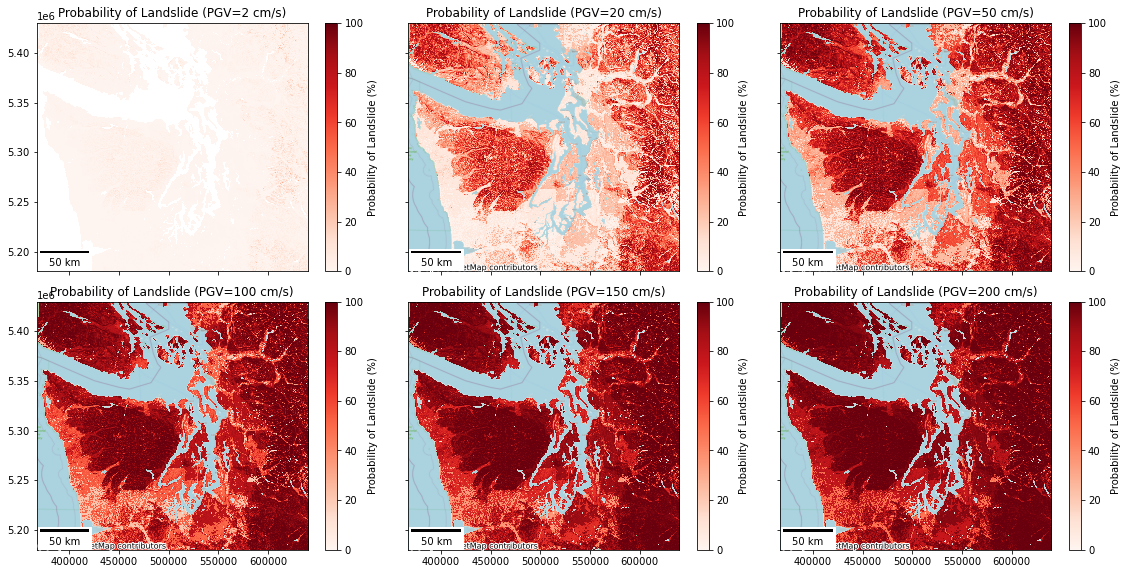

In [47]:
# Plots for each of the raster input parameters (Will choose better colors in the future)

f, ax = plt.subplots(2,3, figsize=(16, 8), sharex=True, sharey=True)

# Probability of Landslide - PGV = 2 cm/s
prob_ls_plot_2 = ax[0][0].imshow(prob_ls_2, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[0][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][0].set_title('Probability of Landslide (PGV=2 cm/s)')
prob_ls_cbar_2 = f.colorbar(prob_ls_plot_2, ax=ax[0][0])
prob_ls_cbar_2.set_label('Probability of Landslide (%)')

# Probability of Landslide - PGV = 20 cm/s
ctx.add_basemap(ax=ax[0][1], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot_20 = ax[0][1].imshow(prob_ls_20, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[0][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][1].set_title('Probability of Landslide (PGV=20 cm/s)')
prob_ls_cbar_20 = f.colorbar(prob_ls_plot_20, ax=ax[0][1])
prob_ls_cbar_20.set_label('Probability of Landslide (%)')

# Probability of Landslide - PGV = 50 cm/s
ctx.add_basemap(ax=ax[0][2], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot_50 = ax[0][2].imshow(prob_ls_50, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[0][2].add_artist(ScaleBar(1.0, location="lower left"))
ax[0][2].set_title('Probability of Landslide (PGV=50 cm/s)')
prob_ls_cbar_50 = f.colorbar(prob_ls_plot_50, ax=ax[0][2])
prob_ls_cbar_50.set_label('Probability of Landslide (%)')

# Probability of Landslide - PGV = 100 cm/s
ctx.add_basemap(ax=ax[1][0], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot_100 = ax[1][0].imshow(prob_ls_100, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[1][0].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][0].set_title('Probability of Landslide (PGV=100 cm/s)')
prob_ls_cbar_100 = f.colorbar(prob_ls_plot_100, ax=ax[1][0])
prob_ls_cbar_100.set_label('Probability of Landslide (%)')

# Probability of Landslide - PGV = 150 cm/s
ctx.add_basemap(ax=ax[1][1], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot_150 = ax[1][1].imshow(prob_ls_150, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[1][1].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][1].set_title('Probability of Landslide (PGV=150 cm/s)')
prob_ls_cbar_150 = f.colorbar(prob_ls_plot_150, ax=ax[1][1])
prob_ls_cbar_150.set_label('Probability of Landslide (%)')

# Probability of Landslide - PGV = 200 cm/s
ctx.add_basemap(ax=ax[1][2], crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot_200 = ax[1][2].imshow(prob_ls_200, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ax[1][2].add_artist(ScaleBar(1.0, location="lower left"))
ax[1][2].set_title('Probability of Landslide (PGV=200 cm/s)')
prob_ls_cbar_200 = f.colorbar(prob_ls_plot_200, ax=ax[1][2])
prob_ls_cbar_200.set_label('Probability of Landslide (%)')


plt.tight_layout()

#### Discussion
* Model outputs when applying a constant PGV ranging from very small to very severe ground motions

## Part 5: Applying the Model - Emergency Response Scenario

### Workflow
* Download Washington State Highway data from WSDOT using wget
* Unzip the zip file and read the Washington State highways shape file using GeoDataFrames read_file
* Reproject to our UTM 10N coordinate system
* Use highways shapefile for analysis in a emergency response scenario

In [48]:
# URL to data
wa_dot_highway_url = 'https://www.wsdot.wa.gov/mapsdata/geodatacatalog/maps/NOSCALE/dot_TDO/LRS/500KLRS_2019.zip'

# Wget is a free GNU command-line utility tool used to download files from the internet. It retrieves files using HTTP, HTTPS, and FTP protocols.
# The -nc option means no clobber (when -nc is specified, this behavior is suppressed, and Wget will refuse to download newer copies of file)
!wget -nc $wa_dot_highway_url

File ‘500KLRS_2019.zip’ already there; not retrieving.



In [49]:
#Unzip
# os.path.split splits the filename wa_dot_highway_url at the last "/" and specifying the -1 retrieves the last part of the split
# In other words, os.path.split is retrieving '500KLRS_2019.zip'
wa_dot_highway_zip_fn = os.path.split(wa_dot_highway_url)[-1]

# Now unzip '500KLRS_2019.zip'
!unzip -n $wa_dot_highway_zip_fn

Archive:  500KLRS_2019.zip


In [50]:
#Load as GeoDataFrame and reproject

# Assign the Wash Dot highways shape functions path to a variable
wa_dot_highway_shp_fn = '500k/sr500klines_20191231.shp'

# read the Wash Dot highway shape function as a GeoDataFrame
highways_gdf = gpd.read_file(wa_dot_highway_shp_fn)

# Reproject to UTM 10N coordinate system
highways_gdf_utm = highways_gdf.to_crs(output_crs)

In [51]:
# Create new gdf of State Route 101
idx_101 = highways_gdf_utm['StateRoute'].isin(['101'])
sr_101 = highways_gdf_utm[idx_101]

# Create new gdf of State Routes 8 and 12
idx_8_and_12 = highways_gdf_utm['StateRoute'].isin(['008','012'])
sr_8_and_12 = highways_gdf_utm[idx_8_and_12]

# Create new gdf of State Route 110
idx_110 = highways_gdf_utm['StateRoute'].isin(['110'])
sr_110 = highways_gdf_utm[idx_110]

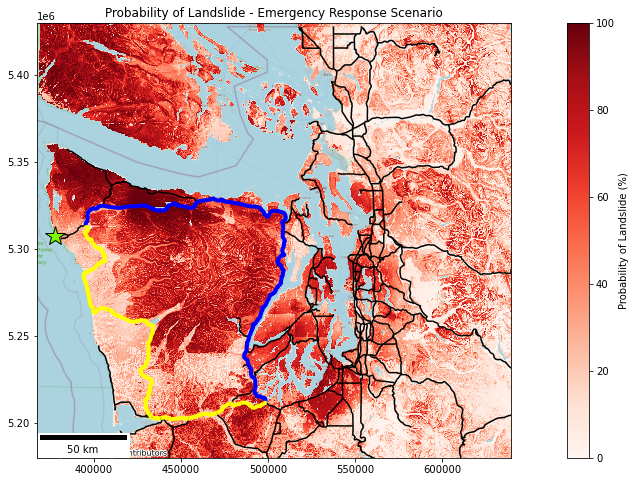

In [52]:
f, ax = plt.subplots(figsize=(20,8))

# Probability of Landslide
# Note, zorder=1 needed so imshow plot shows up in front of basemap
highways_gdf_utm.plot(ax=ax, color='black')
# UTM 10 Coordinates for La Push, Washington
plt.plot(377804.79, 5307383.87, color='lawngreen', marker='*', markersize=20, markeredgecolor='black')


# Highway Option 1 - the blue route
sr_101[24:40].plot(ax=ax, color = 'blue', lw=4)

# Highway Option 2 - the yellow route
sr_101[4:11].plot(ax=ax, color = 'yellow', lw=4)
sr_101[22:24].plot(ax=ax, color = 'yellow', lw=4)
sr_8_and_12[0:11].plot(ax=ax, color = 'yellow', lw=4)

# Plot probability of landslide
prob_ls_plot = ax.imshow(prob_ls, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ctx.add_basemap(ax=ax, crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot = ax.imshow(prob_ls, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');

ax.add_artist(ScaleBar(1.0, location="lower left"))
ax.set_title('Probability of Landslide - Emergency Response Scenario')
prob_ls_cbar = f.colorbar(prob_ls_plot, ax=ax)
prob_ls_cbar.set_label('Probability of Landslide (%)')

#### Discussion:
* We can see the penninsula is the area with the highest probability of landslides (where ground motions are strongest)
* Overlying Washington State highway data allows us to see which highways would be the optimal route to impacted areas
* For example, which route would be most likely landslide free to provide aid to La Push, Washington (green star?) from Seattle?
    * At Olympia you would have to make a decision
        * Option 1 (the blue route)
        * Option 2 (the yellow route)
    * Pose the question to the class
        * We agree, the yellow route looks to be the better option

### Raster Zonal Stats

In [53]:
# Create a buffer of 100 m
buff_width_hwy = 100

# Create new GeoDataSeries of buffered polygons
highways_gdf_utm_wa_buff = highways_gdf_utm.buffer(buff_width_hwy)

#### Now use `rasterstats.zonal_stats` to compute slope statistics
* See the `rasterstats` documentation: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics
* Pass in the probabiliy of landslide NumPy array --> need to provide the appropriate rasterio dataset `transform` to the `affine` keyword
* Compute stats and add the following columns to the `highways_gdf_utm` geodataframe for each highway segment:
    * mean probability of landslide
* Create plot mean probabiliy of landslide

In [54]:
# Our probability of landslide is a numpy masked array with the shape
prob_ls.shape

(1250, 1365)

Therefore, our probability of landslide is in image coordinates and we need to convert them to our projected coordinates using an affine transform

In [55]:
pgv_warp_src.transform

Affine(200.0, 0.0, 367000.0,
       0.0, -200.0, 5430000.0)

Now that we understand this we can now use rasterstats.zonal_stats to compute probability of landslide statistics

In [56]:
# Define the stats we want computed for probability of landslide values within the 100m buffer
stats=['min', 'max', 'mean', 'count', 'std', 'median']

In [57]:
# Compute zonal stats for the buffered highways using rasterstats

# Now compute zonal stats
prob_ls_wa_hwy_stats = rasterstats.zonal_stats(highways_gdf_utm_wa_buff, prob_ls, \
                                            affine=pgv_warp_src.transform, nodata=pgv_warp_src.nodata, stats=stats)

# Note, the "\" is just the line continuation operator, "\"" can be used to split long statements over multiple lines

In [58]:
# We can see our output is a list containing a dictionary
print(type(prob_ls_wa_hwy_stats))
print(type(prob_ls_wa_hwy_stats[0]))

<class 'list'>
<class 'dict'>


To add the hwy stats to a new column in the highways_gdf_utm GeoDataFrame we need to turn our prob_ls_wa_hwy_stats into a GeoDataFrame. We can do this by first creating a Pandas DataFrame

In [59]:
# Lets create a pandas dataframe
prob_ls_wa_hwy_stats_df = pd.DataFrame(prob_ls_wa_hwy_stats, columns=stats)

Now we can create a hwy stats GeoDataFrame from the Pandas DataFrame and then take the stats from our new slope_wa_hwy_stats_gdf and add them to the highways_gdf_utm as the question asks

In [60]:
# Create a hwy stats gdf from the Pandas DataFrame
prob_ls_wa_hwy_stats_gdf = gpd.GeoDataFrame(prob_ls_wa_hwy_stats_df)

# Loop through our list of stats to add each column from the hwy stats gdf to the original highways_gdf_utm
for i in stats:
    highways_gdf_utm[i] = prob_ls_wa_hwy_stats_gdf[i]

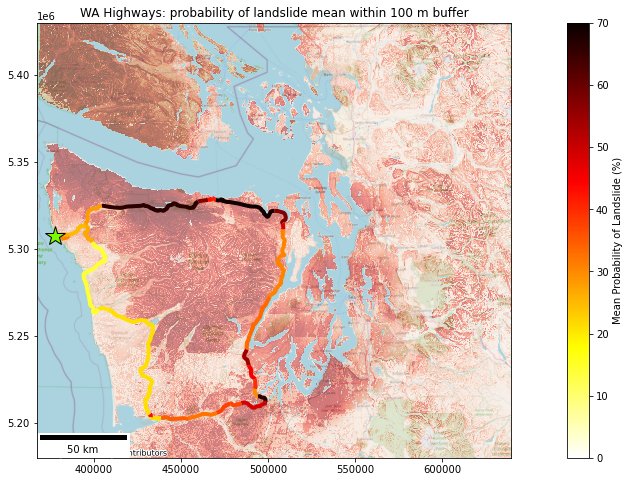

In [61]:
f, ax = plt.subplots(figsize=(20,8))

# Plot highway stats- make sure to plot each highway section with the same scale (max is ~70 so use vmin=0, vmax=70)

# State Route 101
highways_gdf_utm[highways_gdf_utm['StateRoute'].isin(['101'])][24:40].plot(ax=ax, column='mean', cmap='hot_r', linewidth=4, legend=True, \
                                                                           vmin=0, vmax=70, \
                                                                           legend_kwds={'label': "Mean Probability of Landslide (%)"})

highways_gdf_utm[highways_gdf_utm['StateRoute'].isin(['101'])][4:11].plot(ax=ax, column='mean', cmap='hot_r', linewidth=4, vmin=0, vmax=70)
highways_gdf_utm[highways_gdf_utm['StateRoute'].isin(['101'])][22:24].plot(ax=ax, column='mean', cmap='hot_r', linewidth=4, vmin=0, vmax=70)

# State Route 8 and 12
highways_gdf_utm[highways_gdf_utm['StateRoute'].isin(['008','012'])][0:11].plot(ax=ax, column='mean', cmap='hot_r', linewidth=4, vmin=0, vmax=70)

# State Route 110
highways_gdf_utm[highways_gdf_utm['StateRoute'].isin(['110'])].plot(ax=ax, column='mean', cmap='hot_r', linewidth=4, vmin=0, vmax=70)

# UTM 10 Coordinates for La Push, Washington
plt.plot(377804.79, 5307383.87, color='lawngreen', marker='*', markersize=20, markeredgecolor='black')

# Plot probability of landslide
prob_ls_plot = ax.imshow(prob_ls, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none');
ctx.add_basemap(ax=ax, crs=output_crs, source=ctx.providers.OpenStreetMap.Mapnik)
prob_ls_plot = ax.imshow(prob_ls, cmap='Reds', vmin=0, vmax=100, extent=slope_warp_extent, interpolation='none', alpha=0.5)
ax.add_artist(ScaleBar(1.0, location="lower left"))
ax.set_title("WA Highways: probability of landslide mean within 100 m buffer");

### Conclusions
* The Nowicki et al. (2018) model is a good model for rapidly producing probability of landslide maps to help agencies evaluate response strategies after an earthquake.
* The model is useful for identifying areas of high and low probability of landslide for a given earthquake event.
* The limitations of the model are that it uses geospatial information to determine landslide probability and does not realize the benefits of using actual geotechnical data. However, global geospatial parameters allows the model to be used anywhere in the world (not limited to the areas where geotechnical information is available) and give rapid results.

### Results
* Based on the two sets of thresholds, there is more area at low lisk of landslides than high risk within the Puget Lowland. However, the Olympic Peninsula, Tacoma, and Seattle areas will likely have landslides.
* The Nowicki et al. (2018) model tends to spatially overpredict the probability of landslides. Because of the latter the authors introduced a modification factor to represent "the actual probability of a landslide occurring," but provide few details/explanation about it.
    * The USGS uses the model without the correction factor while also applying a couple reasonable limitations (e.g., probability of landslide = 0 if slope < 5 degrees)
* By introducing a constant PGV input into the model a pseudo landslide susceptibility map (still in the form of landslide probability) is produced. The latter allows examination of other factors that influence the probability of landslide. As expected, the probability of landslide is heavily influenced by slope while lithology, landcover, and cti play a smaller role
* The model generates probability of landslide results almost immediately following an earthquake. One use is for emergency response planning as shown in the example for La Push, Washington

### Future Work
As more seismically induced landslides occur an updated model should be developed with new regression coefficients. The lithology and landcover regression coefficients in the current model are not physically sound likely due to the lack of landslides occurring in certain lithologies and landcovers. For example, the lithology unconsolidated sediments has a regression coefficient value of -3.22. The more negative the lithology regression coefficient is the lower the probability of landslide (the stronger the rock). Therefore, unconsolidated sediments, which represent a weak material, currently produces the lowest probability of landslide when it should be on the opposite end of the spectrum. For all facets of the model, as more seismically induced landslides occur the model should become more accurate (assuming the model is updated).

A new geospatial model to predict probability of landslide should include additional parameters that could be used as a proxy for of wetness. Currently compound topographic index is used, but, for how big of factor water plays in landslides, cti has a minor influence in the probability of landslide calculation. There is opportunity to add additional geospatial parameters that can better predict wetness in the ground.

There is an opportunity for researchers to apply machine learning to correlate geospatial parameters to geotechnical (underground) parameters in order to better predict landslide probability.

#### The following are included in the README in a more appropriate format e.g., see Conclusions in the next code block
* Methods results
* Conclusions
* Lessons learned
* Future work

### Conclusions, Results, and Lessons Learned
The Nowicki et al. (2018) model rapidly produces a probability of landslide map following an earthquake event. The model is useful for identifying areas of high and low probability of landslide for a given earthquake event, but values within any specific pixel should not be considered accurate. The model can also be used to help aid agencies evaluate response strategies and be used for loss estimation following earthquake events. The limitations of the model are that it uses geospatial information to determine landslide probability and does not realize the benefits of using actual geotechnical data. However, global geospatial parameters allow the model to be used anywhere in the world (not limited to the areas where geotechnical information is available).

The Nowicki et al. (2018) model was used to calculate the probability of landslide for a Cascadia Subduction Zone scenario earthquake in the NW portion of Washington State and analyze the results. Probability of landslide thresholds were created to mark areas of high and low risk to landslides. Results indicate there is more area at low risk of landslides than high risk within the Puget Lowland. However, the Olympic Peninsula, Tacoma, and Seattle areas will likely to have landslides according to the model. Because the Nowicki et al. (2018) model tends to spatially overpredict the probability of landslides the authors introduced a modification factor to represent "the actual probability of a landslide occurring," but provide few details/explanation about it. The USGS does not use the modification factor and instead applies a couple of reasonable modifications to make the model more physically sound (e.g., the probability of landslide = 0 when the slope is < 5 degrees).

By introducing a constant PGV input into the model a pseudo landslide susceptibility map (still in the form of landslide probability) was produced. The latter allowed examination of factors other than PGV that influence the probability of landslide. As expected, landslide probability is heavily influenced by slope while lithology, landcover, and cti play a smaller role.

The model was also applied for an emergency response scenario for La Push, Washington using the Cascadia Subduction Zone scenario earthquake. The emergency response scenario highlighted the two main routes to La Push, Washington which were evaluated for probability of landslide. Zonal stats on the probability of landslide were used to determine which route was less likely to be impacted by landslides following the earthquake. The route traveling west from Olympia and then north once nearing the ocean was selected. The latter emergency response scenario shows the models applicability for use in aiding emergency response agencies to reach impacted communities following future earthquakes.